<a href="https://colab.research.google.com/github/pavi-rajes/ao_functions_py/blob/Function-consolidation/TCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
os.getcwd() 

my_dir = "/content/drive/My Drive/Colab Notebooks"
os.chdir(my_dir)
os.getcwd() 

'/content/drive/My Drive/Colab Notebooks'

In [ ]:
########################### upload data from local ###########################
from google.colab import files
files.upload()

MessageError: ignored

In [ ]:
########################### import lib & data ###########################
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

dat = pickle.load(open("/content/drive/My Drive/Year_1/Summer_2020/NeuroMatchAcademy/UseTheseSessions/ses13.p", "rb"))
spk = dat["spks"]
# print(dat.keys())

In [ ]:
########################### function for normalization ###########################
# log scaling can't work on neg or 0
# sqrt(raw_spk) --> z-score
def frNormalization(spk):
    spkz=np.sqrt(spk)
    spk_norm = np.zeros_like(spk)
    for cn in range(spkz.shape[0]):
        psth = spkz[cn, :, :]
        #print(psth.shape)
        for trn in range(psth.shape[0]):
            # trlSpk = psth[trn, :] - np.nanmean(psth[trn, :])
            trlSpk = stats.mstats.zscore(psth[trn, :], nan_policy='omit')
            spk_norm[cn, trn, :] = trlSpk

            del trlSpk
        del psth
    return spk_norm

In [ ]:
psth = spk[:, 1, :]
print(psth.shape)

(983, 250)


In [ ]:
[0,0,1, 0, 2, 0, 0,2]

In [ ]:
########################### get the selected regions normalized ###########################
allAreas = dat["brain_area"]
usedAreas = ['CA1', 'VISam', 'PL', 'MOs']
area=dict()
cellN=np.zeros(4)
for i in range(len(usedAreas)):
    areaId = allAreas == usedAreas[i]
    tmp_Area = spk[areaId, :, :]
    # print(tmp_Area.shape)
    area[i] = frNormalization(tmp_Area)
    cellN[i]=tmp_Area.shape[0]

# area contain normalized spikes from selected regions in usedAreas's order [index 0 -3 indicate each region]
# area: row: trials; col: time bins
print(area[0].shape)
print(area[1].shape)

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


(34, 300, 250)
(34, 300, 250)


In [ ]:
print(area[0].shape)
print(area[1].shape)
print(area[2].shape)
print(area[3].shape)

(34, 300, 250)
(34, 300, 250)
(184, 300, 250)
(46, 300, 250)


In [ ]:
# Installing Tensor tools
!pip install git+https://github.com/ahwillia/tensortools

  Cloning https://github.com/ahwillia/tensortools to /tmp/pip-req-build-x918ukiq
  Running command git clone -q https://github.com/ahwillia/tensortools /tmp/pip-req-build-x918ukiq
  Created wheel for tensortools: filename=tensortools-0.3-cp36-none-any.whl size=26267 sha256=c3cd05fb9d99472edbdc42c1202cf9dec4473e344cdbb47e1d95eaba51c269f2
  Stored in directory: /tmp/pip-ephem-wheel-cache-uck9z980/wheels/e4/4f/c6/b7ea145adb6874a9583dfe0c5c8ef3048335f4f885c6ee01ac
Successfully built tensortools


In [ ]:
import tensortools as tt
import numpy as np
import matplotlib.pyplot as plt

# all methods of tensortools:  'cp_als','data','diagnostics','ensemble','kruskal_align', 'mcp_als', 'ncp_bcd', 'ncp_hals', 'operations', 'optimize', 'plot_factors', 'plot_objective','plot_similarity','rand_ktensor', 'randexp_ktensor', 'randn_ktensor', 'tensors', 'visualization']

In [ ]:
# this is frome here: https://gist.github.com/derricw/95eab740e1b08b78c03f 

def bin_ndarray(ndarray, new_shape, operation='sum'):
    """
    Bins an ndarray in all axes based on the target shape, by summing or
        averaging.
    Number of output dimensions must match number of input dimensions.
    Example
    -------
    >>> m = np.arange(0,100,1).reshape((10,10))
    >>> n = bin_ndarray(m, new_shape=(5,5), operation='sum')
    >>> print(n)
    [[ 22  30  38  46  54]
     [102 110 118 126 134]
     [182 190 198 206 214]
     [262 270 278 286 294]
     [342 350 358 366 374]]
    """
    if not operation.lower() in ['sum', 'mean', 'average', 'avg']:
        raise ValueError("Operation {} not supported.".format(operation))
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c//d) for d, c in zip(new_shape,
                                                   ndarray.shape)]
    flattened = [l for p in compression_pairs for l in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        if operation.lower() == "sum":
            ndarray = ndarray.sum(-1*(i+1))
        elif operation.lower() in ["mean", "average", "avg"]:
            ndarray = ndarray.mean(-1*(i+1))
    return ndarray

In [ ]:
new_n_bins = 25
firing_rate = dict()
for iA in range(len(area)):
  iN = area[iA].shape[0]
  iT = area[iA].shape[1]
  # take sum and divide by 0.1 to get firing rate in Hz
  firing_rate[iA]=bin_ndarray(area[iA],new_shape=(iN,iT,new_n_bins),operation='sum') / 0.1 
  print(firing_rate[iA].shape)
#print(firing_rate[0])

(34, 300, 25)
(34, 300, 25)
(184, 300, 25)
(46, 300, 25)


In [ ]:
Xn = firing_rate[2]
R_Xn = np.linalg.matrix_rank(Xn) # finding the rank of our input matrix
print(R_Xn)
print(R_Xn.shape)

[25 25 24 25 25 25 25 16 25 25 25 25 25 25 25  5 24 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 25 25 25 25 25 25 19 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 20 25 24 25 25 25 24 25 25 15 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 25 25 24 25 25 25 25 25 25 25  1 25 25 25 25 25 25
 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 21
 25 25 25 25 25 25 25 15 25 24 25 25 25 25 25 25 25 15 24 25 25 25  9 25
 25 25 23 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25]
(184,)


Rank-1 models:  min obj, 0.91;  max obj, 0.91;  time to fit, 0.3s


Rank-2 models:  min obj, 0.90;  max obj, 0.90;  time to fit, 0.5s


Rank-3 models:  min obj, 0.89;  max obj, 0.90;  time to fit, 0.7s


Rank-4 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 0.5s


Rank-5 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 0.8s


Rank-6 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 1.1s


Rank-7 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 0.7s


Rank-8 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 0.9s


Rank-9 models:  min obj, 0.88;  max obj, 0.89;  time to fit, 1.0s


Rank-10 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 1.2s


Rank-11 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 1.3s


Rank-12 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 1.5s


Rank-13 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 1.5s


Rank-14 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 1.4s


Rank-15 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 1.6s


Rank-16 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 1.6s


Rank-17 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 1.7s


Rank-18 models:  min obj, 0.87;  max obj, 0.88;  time to fit, 1.7s


Rank-19 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 1.7s


Rank-20 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 1.8s


Rank-21 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 2.1s


Rank-22 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 2.1s


Rank-23 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 2.0s


Rank-24 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 2.2s


Rank-25 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 2.1s


Rank-26 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 2.5s


Rank-27 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 2.5s


Rank-28 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 2.6s


Rank-29 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 2.6s


Rank-30 models:  min obj, 0.86;  max obj, 0.87;  time to fit, 2.6s


Rank-31 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 2.6s


Rank-32 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 2.9s


Rank-33 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 2.8s


Rank-34 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 2.6s


Rank-35 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 3.0s


Rank-36 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 2.9s


Rank-37 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 3.0s


Rank-38 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 3.1s


Rank-39 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 3.1s


Rank-40 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 3.0s


Rank-41 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 3.6s


Rank-42 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 3.4s


Rank-43 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 3.6s


Rank-44 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 3.5s


Rank-45 models:  min obj, 0.85;  max obj, 0.86;  time to fit, 3.6s


Rank-46 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 4.1s


Rank-47 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 4.1s


Rank-48 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 3.7s


Rank-49 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 4.0s


Rank-50 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 4.1s


Rank-51 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 4.0s


Rank-52 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 4.2s


Rank-53 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 4.4s


Rank-54 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 4.3s


Rank-55 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 4.6s


Rank-56 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 4.4s


Rank-57 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 4.3s


Rank-58 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 4.8s


Rank-59 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 5.0s


Rank-60 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 4.7s


Rank-61 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 5.3s


Rank-62 models:  min obj, 0.84;  max obj, 0.85;  time to fit, 5.3s


Rank-63 models:  min obj, 0.84;  max obj, 0.85;  time to fit, 5.3s


Rank-64 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 4.8s


Rank-65 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 5.4s


Rank-66 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 5.3s


Rank-67 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 5.4s


Rank-68 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 5.6s


Rank-69 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 5.5s


Rank-70 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 6.3s


Rank-71 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 6.1s


Rank-72 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 5.7s


Rank-73 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 5.6s


Rank-74 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 5.7s


Rank-75 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 6.3s


Rank-76 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 6.2s


Rank-77 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 6.2s


Rank-78 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 6.1s


Rank-79 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 6.3s


Rank-80 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 6.6s


Rank-81 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 6.6s


Rank-82 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 6.9s


Rank-83 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 6.7s


Rank-84 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 6.7s


Rank-85 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 6.7s


Rank-86 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 6.8s


Rank-87 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 6.7s


Rank-88 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 7.2s


Rank-89 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 7.0s


Rank-90 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 7.2s


Rank-91 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 6.7s


Rank-92 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 7.0s


Rank-93 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 7.6s


Rank-94 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 7.5s


Rank-95 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 7.4s


Rank-96 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 7.5s


Rank-97 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 8.1s


Rank-98 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 7.7s


Rank-99 models:  min obj, 0.83;  max obj, 0.83;  time to fit, 8.4s


Rank-1 models:  min obj, 0.91;  max obj, 0.91;  time to fit, 0.2s


Rank-2 models:  min obj, 0.90;  max obj, 0.91;  time to fit, 0.7s


Rank-3 models:  min obj, 0.90;  max obj, 0.90;  time to fit, 1.8s


Rank-4 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 1.8s


Rank-5 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 2.2s


Rank-6 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 2.3s


Rank-7 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 2.1s


Rank-8 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 2.7s


Rank-9 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 2.9s


Rank-10 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 3.2s


Rank-11 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 3.1s


Rank-12 models:  min obj, 0.88;  max obj, 0.89;  time to fit, 3.1s


Rank-13 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 3.8s


Rank-14 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 3.6s


Rank-15 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 4.0s


Rank-16 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 3.9s


Rank-17 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 4.6s


Rank-18 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 4.9s


Rank-19 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 5.0s


Rank-20 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 5.3s


Rank-21 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 5.5s


Rank-22 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 5.3s


Rank-23 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 6.0s


Rank-24 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 5.9s


Rank-25 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 6.2s


Rank-26 models:  min obj, 0.87;  max obj, 0.88;  time to fit, 7.4s


Rank-27 models:  min obj, 0.87;  max obj, 0.88;  time to fit, 6.7s


Rank-28 models:  min obj, 0.87;  max obj, 0.88;  time to fit, 7.2s


Rank-29 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 7.0s


Rank-30 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 7.3s


Rank-31 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 8.1s


Rank-32 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 7.5s


Rank-33 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 8.0s


Rank-34 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 8.3s


Rank-35 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 9.0s


Rank-36 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 9.1s


Rank-37 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 9.5s


Rank-38 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 9.9s


Rank-39 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 10.2s


Rank-40 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 10.0s


Rank-41 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 9.9s


Rank-42 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 9.9s


Rank-43 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 10.7s


Rank-44 models:  min obj, 0.86;  max obj, 0.87;  time to fit, 11.1s


Rank-45 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 11.0s


Rank-46 models:  min obj, 0.86;  max obj, 0.87;  time to fit, 12.0s


Rank-47 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 12.0s


Rank-48 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 12.0s


Rank-49 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 12.3s


Rank-50 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 12.0s


Rank-51 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 13.6s


Rank-52 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 13.1s


Rank-53 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 13.5s


Rank-54 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 12.9s


Rank-55 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 14.7s


Rank-56 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 14.8s


Rank-57 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 14.3s


Rank-58 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 14.5s


Rank-59 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 14.7s


Rank-60 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 14.8s


Rank-61 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 15.1s


Rank-62 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 15.4s


Rank-63 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 15.4s


Rank-64 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 14.6s


Rank-65 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 16.7s


Rank-66 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 17.2s


Rank-67 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 16.8s


Rank-68 models:  min obj, 0.85;  max obj, 0.86;  time to fit, 16.9s


Rank-69 models:  min obj, 0.85;  max obj, 0.86;  time to fit, 17.8s


Rank-70 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 17.8s


Rank-71 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 16.7s


Rank-72 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 17.5s


Rank-73 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 17.5s


Rank-74 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 18.4s


Rank-75 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 18.0s


Rank-76 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 18.2s


Rank-77 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 18.6s


Rank-78 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 18.3s


Rank-79 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 19.1s


Rank-80 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 18.6s


Rank-81 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 20.0s


Rank-82 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 19.3s


Rank-83 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 19.4s


Rank-84 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 19.4s


Rank-85 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 19.8s


Rank-86 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 19.9s


Rank-87 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 20.0s


Rank-88 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 21.2s


Rank-89 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 20.3s


Rank-90 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 21.0s


Rank-91 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 20.8s


Rank-92 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 21.7s


Rank-93 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 21.9s


Rank-94 models:  min obj, 0.84;  max obj, 0.85;  time to fit, 22.6s


Rank-95 models:  min obj, 0.84;  max obj, 0.85;  time to fit, 22.8s


Rank-96 models:  min obj, 0.84;  max obj, 0.85;  time to fit, 23.2s


Rank-97 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 24.2s


Rank-98 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 25.2s


Rank-99 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 25.8s


Rank-1 models:  min obj, 0.91;  max obj, 0.91;  time to fit, 0.1s


Rank-2 models:  min obj, 0.90;  max obj, 0.90;  time to fit, 0.4s


Rank-3 models:  min obj, 0.90;  max obj, 0.90;  time to fit, 0.5s


Rank-4 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 0.5s


Rank-5 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 0.5s


Rank-6 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 0.6s


Rank-7 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 0.6s


Rank-8 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 0.6s


Rank-9 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 0.8s


Rank-10 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 0.9s


Rank-11 models:  min obj, 0.88;  max obj, 0.89;  time to fit, 1.0s


Rank-12 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 1.0s


Rank-13 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 1.0s


Rank-14 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 1.1s


Rank-15 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 1.2s


Rank-16 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 1.1s


Rank-17 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 1.1s


Rank-18 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 1.2s


Rank-19 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 1.4s


Rank-20 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 1.4s


Rank-21 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 1.4s


Rank-22 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 1.3s


Rank-23 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 1.7s


Rank-24 models:  min obj, 0.87;  max obj, 0.88;  time to fit, 1.6s


Rank-25 models:  min obj, 0.87;  max obj, 0.88;  time to fit, 1.6s


Rank-26 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 1.9s


Rank-27 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 2.0s


Rank-28 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 1.8s


Rank-29 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 2.1s


Rank-30 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 2.0s


Rank-31 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 1.9s


Rank-32 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 2.2s


Rank-33 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 2.1s


Rank-34 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 2.2s


Rank-35 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 3.0s


Rank-36 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 2.5s


Rank-37 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 2.3s


Rank-38 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 2.7s


Rank-39 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 2.9s


Rank-40 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 2.7s


Rank-41 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 2.6s


Rank-42 models:  min obj, 0.86;  max obj, 0.87;  time to fit, 3.0s


Rank-43 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 3.1s


Rank-44 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 3.3s


Rank-45 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 3.3s


Rank-46 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 3.4s


Rank-47 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 3.5s


Rank-48 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 3.4s


Rank-49 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 3.2s


Rank-50 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 3.2s


Rank-51 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 4.0s


Rank-52 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 3.5s


Rank-53 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 3.8s


Rank-54 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 3.6s


Rank-55 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 4.3s


Rank-56 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 3.8s


Rank-57 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 4.0s


Rank-58 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 4.1s


Rank-59 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 4.8s


Rank-60 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 4.3s


Rank-61 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 4.7s


Rank-62 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 5.1s


Rank-63 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 4.8s


Rank-64 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 4.4s


Rank-65 models:  min obj, 0.85;  max obj, 0.86;  time to fit, 4.9s


Rank-66 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 5.1s


Rank-67 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 5.6s


Rank-68 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 6.3s


Rank-69 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 5.5s


Rank-70 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 5.9s


Rank-71 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 5.8s


Rank-72 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 5.6s


Rank-73 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 6.0s


Rank-74 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 5.2s


Rank-75 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 5.6s


Rank-76 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 6.5s


Rank-77 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 5.9s


Rank-78 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 6.2s


Rank-79 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 6.8s


Rank-80 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 6.5s


Rank-81 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 6.8s


Rank-82 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 6.7s


Rank-83 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 6.7s


Rank-84 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 6.0s


Rank-85 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 7.5s


Rank-86 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 7.4s


Rank-87 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 7.0s


Rank-88 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 6.9s


Rank-89 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 6.8s


Rank-90 models:  min obj, 0.84;  max obj, 0.85;  time to fit, 7.6s


Rank-91 models:  min obj, 0.84;  max obj, 0.85;  time to fit, 6.9s


Rank-92 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 7.0s


Rank-93 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 7.3s


Rank-94 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 7.4s


Rank-95 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 7.6s


Rank-96 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 7.6s


Rank-97 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 9.1s


Rank-98 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 9.4s


Rank-99 models:  min obj, 0.84;  max obj, 0.84;  time to fit, 8.4s


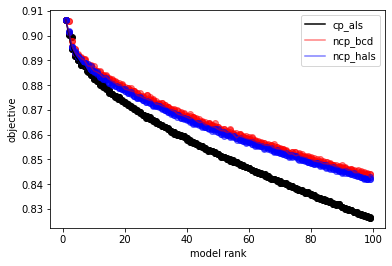

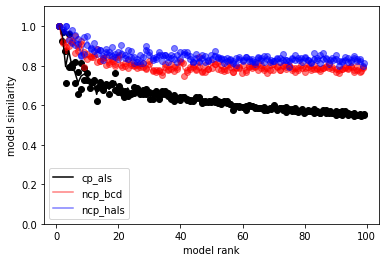

In [ ]:
# this script is for similarity score and error plot from cpd_ensemble.py (Alex- Github)

# Fit ensembles of tensor decompositions.
methods = (
  'cp_als',    # fits unconstrained tensor decomposition.
  'ncp_bcd',   # fits nonnegative tensor decomposition.
  'ncp_hals',  # fits nonnegative tensor decomposition.
)


ensembles = {}
for m in methods:
    ensembles[m] = tt.Ensemble(fit_method=m, fit_options=dict(tol=1e-4))
    ensembles[m].fit(Xn, ranks=range(1, 100), replicates=3)

# Plotting options for the unconstrained and nonnegative models.
plot_options = {
  'cp_als': {
    'line_kw': {
      'color': 'black',
      'label': 'cp_als',
    },
    'scatter_kw': {
      'color': 'black',
    },
  },
  'ncp_hals': {
    'line_kw': {
      'color': 'blue',
      'alpha': 0.5,
      'label': 'ncp_hals',
    },
    'scatter_kw': {
      'color': 'blue',
      'alpha': 0.5,
    },
  },
  'ncp_bcd': {
    'line_kw': {
      'color': 'red',
      'alpha': 0.5,
      'label': 'ncp_bcd',
    },
    'scatter_kw': {
      'color': 'red',
      'alpha': 0.5,
    },
  },
}

# Plot similarity and error plots.
plt.figure()
for m in methods:
    tt.plot_objective(ensembles[m], **plot_options[m])
plt.legend()

plt.figure()
for m in methods:
    tt.plot_similarity(ensembles[m], **plot_options[m])
plt.legend()

plt.show()

In [ ]:
# X - tensor input 
# figure out what should be the rank of the input matrix 

X = firing_rate[2]
R =3

U = tt.cp_als(X, rank= R, verbose = True)
V= tt.cp_als(X,rank=R,verbose=True)

CP_ALS: iteration 1, objective 0.9552078457315368, improvement inf.
CP_ALS: iteration 2, objective 0.9001241008665751, improvement 0.0550837448649617.
CP_ALS: iteration 3, objective 0.8976450265043211, improvement 0.00247907436225403.
CP_ALS: iteration 4, objective 0.8964525883366832, improvement 0.0011924381676379214.
CP_ALS: iteration 5, objective 0.8960027106077266, improvement 0.0004498777289565492.
CP_ALS: iteration 6, objective 0.8958302073834482, improvement 0.0001725032242784197.
CP_ALS: iteration 7, objective 0.895713260831363, improvement 0.00011694655208516203.
CP_ALS: iteration 8, objective 0.8956064541686433, improvement 0.00010680666271978279.
CP_ALS: iteration 9, objective 0.8955010251498533, improvement 0.0001054290187899598.
CP_ALS: iteration 10, objective 0.8953950827169324, improvement 0.00010594243292094685.
CP_ALS: iteration 11, objective 0.895288514619034, improvement 0.00010656809789832966.
CP_ALS: iteration 12, objective 0.8951818939350277, improvement 0.0001066

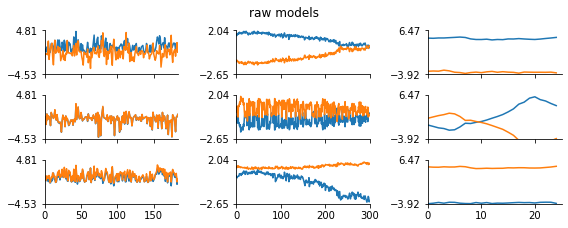

In [ ]:
fig, ax, po = tt.plot_factors(U.factors)
#fig.figsize=(20,16)
tt.plot_factors(V.factors, fig=fig)
fig.suptitle("raw models",y=1.04)
fig.tight_layout()

0.8676319140746164


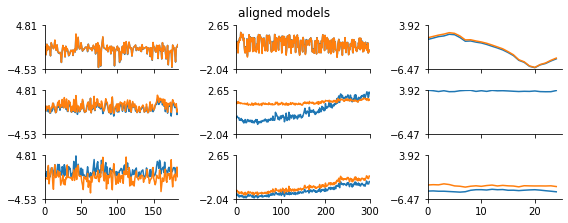

In [ ]:
# Align the two fits and print a similarity score.
sim = tt.kruskal_align(U.factors, V.factors, permute_U=True, permute_V=True) # sim is the similarity score 
print(sim)

# Plot the results again to see alignment.
fig, ax, po = tt.plot_factors(U.factors)
tt.plot_factors(V.factors, fig=fig)
fig.suptitle("aligned models",y=1.02)
fig.tight_layout()

# Show plots.
plt.show()

In [ ]:
X_all = np.concatenate([firing_rate[0],firing_rate[1],firing_rate[2],firing_rate[3]],0)
#X = np.hstack(firing_rate[1])
print(X_all.shape)


(298, 300, 25)


CP_ALS: iteration 1, objective 0.9895573163375165, improvement inf.
CP_ALS: iteration 2, objective 0.9010405897528545, improvement 0.08851672658466203.
CP_ALS: iteration 3, objective 0.8985393308556159, improvement 0.002501258897238623.
CP_ALS: iteration 4, objective 0.8965344350525687, improvement 0.002004895803047191.
CP_ALS: iteration 5, objective 0.8951773011055956, improvement 0.0013571339469731214.
CP_ALS: iteration 6, objective 0.8948586527645693, improvement 0.00031864834102623973.
CP_ALS: iteration 7, objective 0.8947414668908014, improvement 0.00011718587376796652.
CP_ALS: iteration 8, objective 0.8946765158907937, improvement 6.495100000769582e-05.
CP_ALS: iteration 9, objective 0.8946319997110219, improvement 4.451617977174749e-05.
CP_ALS: iteration 10, objective 0.8945967976116572, improvement 3.5202099364695094e-05.
CP_ALS: iteration 11, objective 0.8945659849915939, improvement 3.081262006332519e-05.
CP_ALS: iteration 12, objective 0.8945370550405569, improvement 2.89299

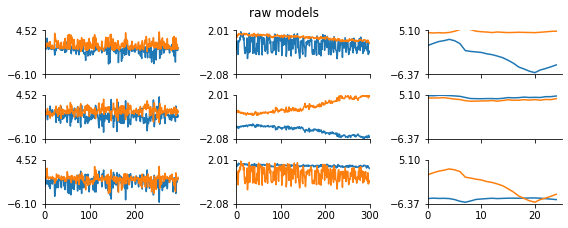

In [ ]:
R =3

U = tt.cp_als(X_all, rank= R, verbose = True)
V= tt.cp_als(X_all,rank=R,verbose=True)

fig, ax, po = tt.plot_factors(U.factors)
#fig.figsize=(20,16)
tt.plot_factors(V.factors, fig=fig)
fig.suptitle("raw models",y=1.04)
fig.tight_layout()

0.9799431684637466


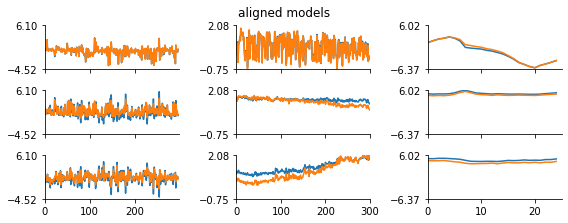

In [ ]:
# Align the two fits and print a similarity score.
sim = tt.kruskal_align(U.factors, V.factors, permute_U=True, permute_V=True) # sim is the similarity score 
print(sim)

# Plot the results again to see alignment.
fig, ax, po = tt.plot_factors(U.factors)
tt.plot_factors(V.factors, fig=fig)
fig.suptitle("aligned models",y=1.02)
fig.tight_layout()

# Show plots.
plt.show()

In [ ]:
# TODO - not needed for Tensor 
def moveMean_step(stepSize,data,axis): 
  # now only work up to 2 D
  in_n=data.shape[axis]
  out_n=np.ceil(in_n/stepSize)
  if axis==0:
    out_mat=np.zeros((out_n,data.shape[1]))
  else:
    out_mat=np.zeros((out_n,data.shape[0]))
  for i in range(out_n):
    



  



In [ ]:
########################### defined the whole trial matrix for PCA ###########################
smpCellN=int(np.min(cellN))
MOs = area[len(area)-1] # in reality loop through each region
cell_i = np.random.choice(np.arange(0,MOs.shape[0]+1), smpCellN, replace=False)
MOs_sampled = MOs[cell_i,:,:]

for i in range(MOs_sampled.shape[1]):
    if i == 0:
        MOs_mat = np.rollaxis(MOs_sampled[:,i,:], 1, 0)
    else:
        tmp = np.rollaxis(MOs_sampled[:,1,:], 1, 0)
        MOs_mat = np.append(MOs_mat, tmp, axis=0)
print(MOs_mat.shape)
# the data is now down sampled to 34 neurons without replacement 
# (34 is the min cell num across regions)
# this session has 300 trils and 250 bins each 
# so MOs_mat now has 34 columns and 75000(=250*300) rows

# we'll bin then into 25*300 rows where 
# each row has 100 ms averaged FR, not overlapped in time








(75000, 34)


In [ ]:
########################### estimate sig PCs for whole trial ###########################

In [ ]:
########################### define a event by time bin matrix  ###########################

In [ ]:
########################### estimate sig PCs for events ###########################